__EzTao__ is a Python toolkit for conducting time-series analysis using continuous-time autoregressive moving average (CARMA) processes. It uses [$\mathit{celerite}$](https://github.com/dfm/celerite) to compute the likelihood given an input time series and a set of proposed CARMA parameters. Comparing to existing tools (e.g., [$\mathit{Kali}$](https://github.com/AstroVPK/kali)) for performing CARMA analysis in Python, __EzTao__ offers a more scalable solution. A short introduction to CARMA, $\mathit{celerite}$ and __EzTao__ is presented below.

### Continuous-time Autoregressive Moving Average Process (CARMA)

CARMA is the continuous-time version of the better known autoregressive moving average or ARMA model. CARMA models are being utilized to study time-domain data across many disciplines. In short, CARMA processes are defined as the solutions to the following stochastic differential equation:

$$\mathrm{d}^{p}x + \alpha_{1} \mathrm{d}^{p-1}x + \ldots + \alpha_{p-1} \mathrm{d}x + \alpha_{p}x = \beta_{0} (\mathrm{d}W) + \ldots + \beta_{q} \mathrm{d}^{q}(\mathrm{d}W)$$

$\alpha$ and $\beta$ are the parameters of a CARMA model. The order of the underlying differential equation can be specified using two numbers $p$ and $q$, where $p$ is the AR order and $q$ is the MA order. Thus, a particular CARMA model can also be referred to as a CARMA(p,q) model. For example, a CARMA(2,1) model will have a corresponding stochastic differential equation defined by:

$$\mathrm{d}^{2}x + \alpha_{1} \mathrm{d}x + \alpha_{2}x = \beta_{0} (\mathrm{d}W) + \beta_{1} \mathrm{d}^{1}(\mathrm{d}W)$$

In fact, the well-known Damped Random Walk (DRW) model is simply the lowest order CARMA model, namely CARMA(1,0) with a stochastic differential equation defined by:

$$\mathrm{d}x + \alpha_{1}x = \beta_{0} (\mathrm{d}W) $$

For more on CARMA models, please see:
- [Jones & Ackerson 1990](https://www.jstor.org/stable/2337095?origin=crossref&seq=1)
- [Brockwell 2001](https://www.sciencedirect.com/science/article/pii/S0169716101190115?via%3Dihub)
- [Kelly et al. 2014](http://iopscience.iop.org/article/10.1088/0004-637X/788/1/33/meta)
- [Kasliwal et al. 2017](https://academic.oup.com/mnras/article/470/3/3027/3865153)


### `celerite` and CARMA

Previously, the evaluation of CARMA's likelihood function utilizes Kalman filtering in the state-space of CARMA. Although this approach scales linearly with the number of data points in the input time series, the total computational cost is still too high to be considered scalable, especially for analyzing time series with more than ~500 data points and using CARMA models higher than CARMA(2,1). 

$\mathit{celerite}$ is a library to perform Gaussian Process (GP) modeling at scale. By definition, CARMA processes that are driven by Gaussian noises are indeed GPs. Therefore, we can utilize $\mathit{celerite}$ to speed up the likelihood evaluation by parameterizing CARMA models in terms of $\mathit{celerite}$ models. 

For more on $\mathit{celerite}$, please see the original $\mathit{celerite}$ [paper](https://iopscience.iop.org/article/10.3847/1538-3881/aa9332).

### __EzTao__

__EzTao__ develops on top of the idea introduced above with a goal to enable scalable CARMA modeling and to facilitate the study of astronomical time series using CARMA. __EzTao__ consist of tools to both simulate CARMA processes and fit (MLE) time series to CARMA models. The current version of __EzTao__ is based on $\mathit{celerite}$, and future versions will be built on top of $\mathit{celerite2}$ with better support for integration with other probabilistic programing libraries such as $\mathit{PyMC3}$. 

---
### A Quick Demo
Next, we will walk through a few examples with explaining in-detail what each function does.

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
%matplotlib inline

import eztao
from eztao.carma import DRW_term
from eztao.ts import gpSimRand
from eztao.ts import drw_fit
from celerite import GP

mpl.rc_file(os.path.join(eztao.__path__[0], "viz/eztao.rc"))

- #### Simulate a DRW process

In [2]:
# initialize a DRW model
amp = 0.3
tau = 100
DRW_kernel = DRW_term(np.log(amp), np.log(tau))

# simulate a process using the above model
t, y, yerr = gpSimRand(DRW_kernel, 10, 365*10, 200)

Text(0.5, 1.0, 'Simulated DRW process')

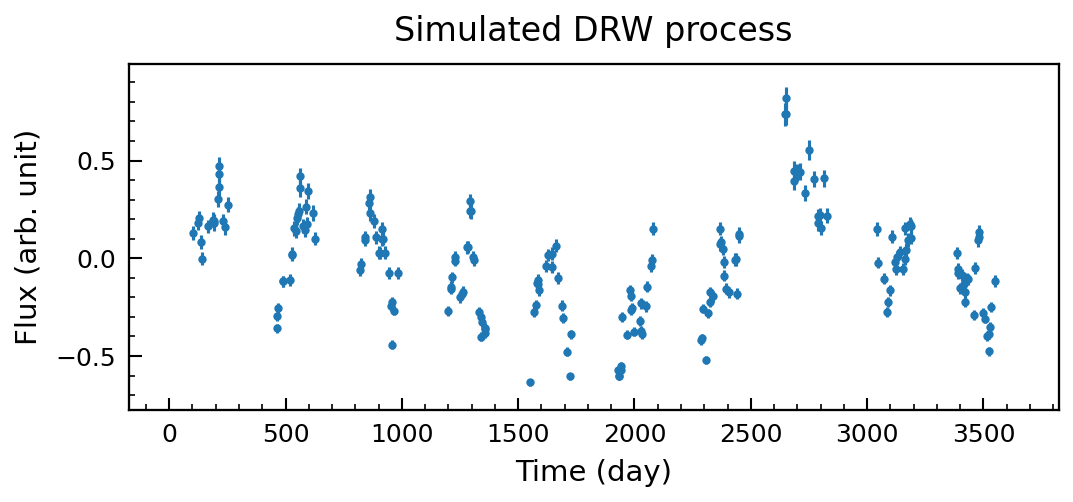

In [3]:
# plot the simulated process
fig, ax = plt.subplots(1,1, dpi=150, figsize=(8,3))
ax.errorbar(t, y, yerr, fmt='.')
ax.set_xlabel('Time (day)')
ax.set_ylabel('Flux (arb. unit)')
ax.set_title('Simulated DRW process')

- #### Fit the simulated DRW process

In [4]:
best_fit = drw_fit(t, y, yerr)
print(f'Best-fit DRW parameter: {best_fit}')

Best-fit DRW parameter: [ 0.29143129 97.68998723]


- #### Compare True PSD vs Best-fit PSD

In [5]:
from eztao.carma import gp_psd

In [6]:
true_psd = gp_psd(DRW_kernel)
best_psd = gp_psd(DRW_term(*np.log(best_fit)))

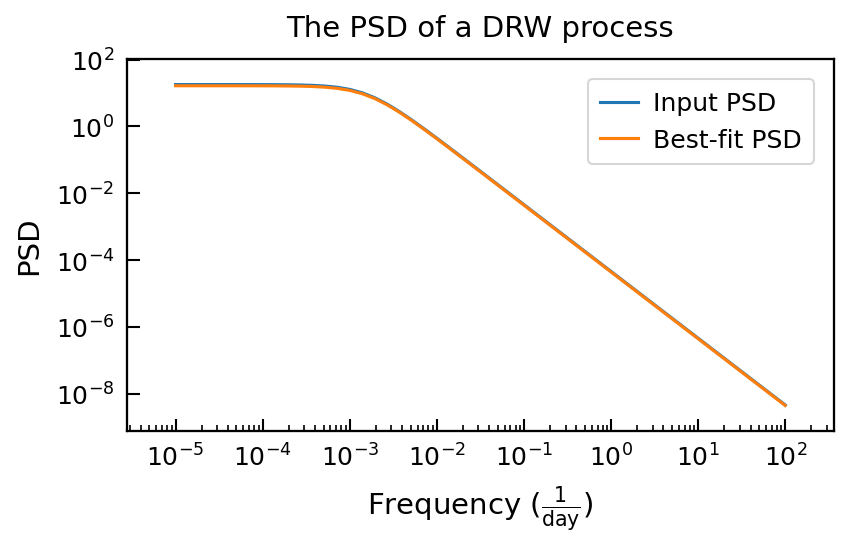

In [7]:
fig, ax = plt.subplots(1,1, dpi=150, figsize=(6,4))
freq = np.logspace(-5, 2)
ax.plot(freq, true_psd(freq), label='Input PSD')
ax.plot(freq, best_psd(freq), label='Best-fit PSD')
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel(r'Frequency ($\frac{1}{\mathrm{day}}$)')
ax.set_ylabel('PSD')
ax.set_title('The PSD of a DRW process', fontsize=14)
ax.legend()
fig.tight_layout()

__Note:__ Here, we are using DRW models for demonstration purpose only, the same analysis can be applied using any CARMA models. We will show that in the in the next few notebooks.